#### Introduction

I'm going to use the video game sales data from last week as gaming is a hobby for me and I find this data engaging. The data has 16 columns and over sixteen thousand rows. It has columns to describe the game, such as the platform, genre, and publisher. It also has columns to describe the sales broken out by region. Lastly, it has critic and user scores. It has numerous forms of missing data, so filtering out rows that are missing data will be a common step in preparing the data.

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

data = pd.read_csv('Video_Games_Sales_as_at_22_Dec_2016.csv')
print(data.head(10))
rows,columns=data.shape
print("\nThe data has {} rows and {} columns".format(rows,columns))

                        Name Platform  Year_of_Release         Genre  \
0                 Wii Sports      Wii           2006.0        Sports   
1          Super Mario Bros.      NES           1985.0      Platform   
2             Mario Kart Wii      Wii           2008.0        Racing   
3          Wii Sports Resort      Wii           2009.0        Sports   
4   Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing   
5                     Tetris       GB           1989.0        Puzzle   
6      New Super Mario Bros.       DS           2006.0      Platform   
7                   Wii Play      Wii           2006.0          Misc   
8  New Super Mario Bros. Wii      Wii           2009.0      Platform   
9                  Duck Hunt      NES           1984.0       Shooter   

  Publisher  NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  \
0  Nintendo     41.36     28.96      3.77         8.45         82.53   
1  Nintendo     29.08      3.58      6.81         0.77         

#### Questions

There are several questions that come to mind from this dataset, but I want to focus in on these three:
1. Are user scores related to user counts? Do games with more users get lower or higher scores?
1. How do the regional sales of the pubishers differ?
1. How have sales by publisher changed over time?

#### 1. Are user scores related to user counts?

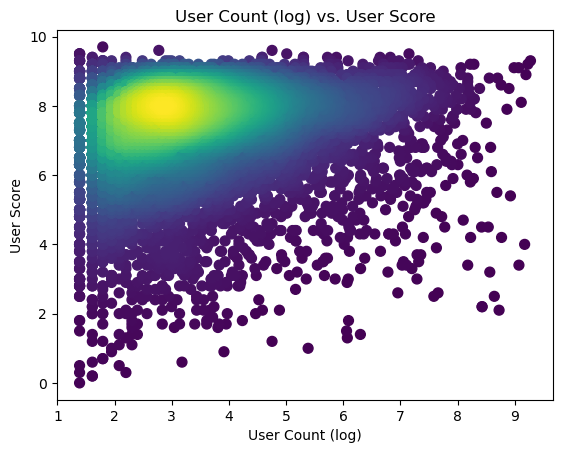

In [91]:
# Make a copy of just the columns we need.
scores = data[['User_Score','User_Count']].copy()

# Make sure numeric columns only have numeric data.
scores['User Score'] = pd.to_numeric(data['User_Score'], errors='coerce')

# Make the user count column logarithmic since the range of values is so large.
scores['User Count (log)'] = np.log(scores['User_Count'])

# Drop missing values
scores = scores.dropna()

# Here is a function to plot a scatter plot with density,
# adapted from https://stackoverflow.com/a/20107592.
def density_scatter(df,x_name,y_name):
    x,y = df[x_name].to_numpy(),df[y_name].to_numpy()
    
    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    fig, ax = plt.subplots()
    cax = ax.scatter(x, y, c=z, s=50, edgecolor=None)
    plt.title(x_name +" vs. "+y_name)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.show()
    
density_scatter(scores,'User Count (log)','User Score')

#### 2. How do the regional sales of the pubishers differ?

In [92]:
# Make a copy of just the data we need.
sales = data[['Publisher','NA_Sales','EU_Sales','JP_Sales','Other_Sales','Global_Sales']].copy()

# Make sure numeric columns only have numeric data.
sales['NA_Sales'] = pd.to_numeric(sales['NA_Sales'], errors='coerce')
sales['EU_Sales'] = pd.to_numeric(sales['EU_Sales'], errors='coerce')
sales['JP_Sales'] = pd.to_numeric(sales['JP_Sales'], errors='coerce')
sales['Other_Sales'] = pd.to_numeric(sales['Other_Sales'], errors='coerce')
sales['Global_Sales'] = pd.to_numeric(sales['Global_Sales'], errors='coerce')

# Group by publisher
sales = sales.dropna().groupby('Publisher').sum()

# Select the top ten publishers by global sales
sales = sales.sort_values('Global_Sales',ascending=False).head(10)

# Resent the index so we can use the Publisher column
sales = sales.reset_index()


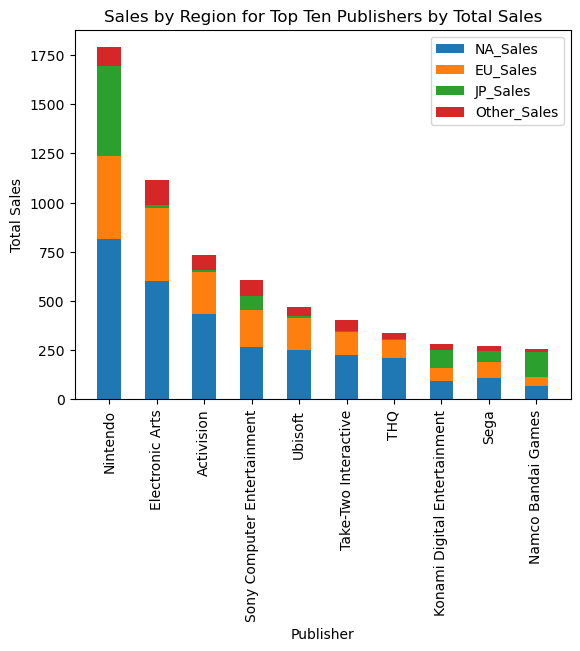

In [93]:
# Prepare the data for plotting.
width = 0.5
publishers = list(sales['Publisher'])
weight_counts = {
    "NA_Sales": sales['NA_Sales'],
    "EU_Sales": sales['EU_Sales'],
    "JP_Sales": sales['JP_Sales'],
    "Other_Sales": sales['Other_Sales']
}
fig, ax = plt.subplots()
bottom = np.zeros(len(sales))

# For each sale type, stack the bars on top of each other.
for sale_type, weight_count in weight_counts.items():
    p = ax.bar(publishers, weight_count, width, label=sale_type, bottom=bottom)
    bottom += weight_count

# Make the graph user-friendly and show it.
ax.set_title("Sales by Region for Top Ten Publishers by Total Sales")
ax.legend(loc="upper right")
ax.tick_params(axis='x', labelrotation=90)
plt.xlabel("Publisher")
plt.ylabel("Total Sales")
plt.show()

#### 3. How have sales by publisher changed over time?

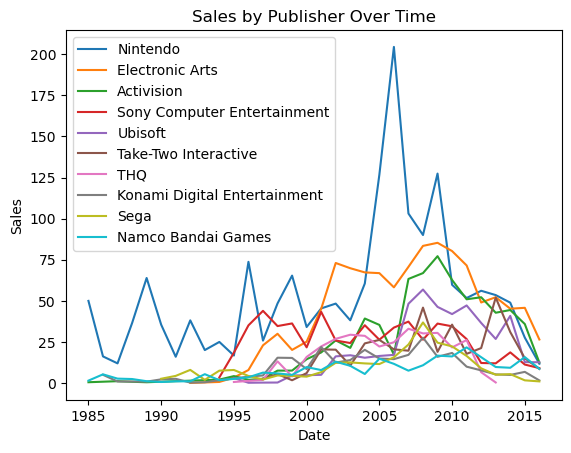

In [94]:
# Make a copy of just the data we need.
lines = data[['Publisher','Global_Sales','Year_of_Release']].copy()

# Make numeric columns only hold numeric data and drop invalid rows.
lines['Global_Sales'] = pd.to_numeric(lines['Global_Sales'], errors='coerce')
lines['Year_of_Release'] = pd.to_numeric(lines['Year_of_Release'], errors='coerce')
lines = lines.dropna()
lines['Year_of_Release'] = lines['Year_of_Release'].astype(int)

# Group by publisher and year, resetting the index so we can use these columns.
lines = lines.groupby(['Publisher','Year_of_Release']).sum()
lines = lines.reset_index()

# Trim outliers
lines = lines.loc[lines['Year_of_Release'] <= 2016]
lines = lines.loc[lines['Year_of_Release'] >= 1985]

# Add a line for each publisher.
for publisher in publishers:
    single_line = lines.loc[lines['Publisher'] == publisher]
    plt.plot(single_line['Year_of_Release'],single_line['Global_Sales'],label=publisher)

# Make the graph user-friendly and show it.
plt.title('Sales by Publisher Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


#### Insights

From the first graph, comparing user score and user count, it is clear there is in fact a relationship between user count and user score, with an upward trend of scores as user count increases. Of course, correlation does not imply causation. Are the games more popular because they score better, or do they score better because they are more popular? In either case, this visualzation shows there is a relations and it would be interesting to explore this relationship further.

From the second graph, on regional sales by publisher, the most variability is in the Japan sales. Most of the other categories are relatively proportional to each other and to other publishers, but the Japan sales are very small for US-based publishers (e.g. Activision, Ubisoft) but are much larger for Japanese-based publishers (e.g. Nintendo, Sony). It is also quite clear that Nintendo has a commanding lead over any other publisher.

From the third graph, on publisher sales over time, it is clear that some publishers did not start making sales until the late nineties. It would also be interesting to explore what caused such a spike in Nintento sales around 2005-2010. The graph trails at the end, but that is because there was not enough time to collect sales which would have still been going strong for recent titles. There is a pretty noticeable spike across several publishers round 2008-2010, which would be interesting to explore further.

#### Conclusion

In any type of data exploration and visualization process there will be more questions that come as initial questions are answered. This exercise proved no different. While the visualzation demonstrated a relationship between user score and user count, it did not explain why that relationship existed and which direction is the causation. More exploration and analysis would be needed to solve these new questions. Similarly, visualizing how various publishers perform differently in Japan versus the US and Europe answers the questions about those figures, but does not explain why the publishers perform differently in the different markets. It would be interesting to explore genre, scores, and analyze the specific games a little deeper to understand if publishers specialize in different kind of content that is desired regionally. Perfhaps, instead, it is simply a matter of marketing and brand name recognition. Lastly, showing sales by year and publisher shows variability from one year to the next as some releases do better than others and it pinpoints periods of time that warrant further analysis. In all, visualzation answers questions and lays the foundation for even further analysis. Visualization is an essential tool throughout the data science process.